In [1]:
# Import dependancies
import numpy as np
import pandas as pd
import os
import pickle

data_path = '/Users/muneeza/Documents/GitHub/DATA_SWAT/hru_region02_np_arr'
save_dir = '/Users/muneeza/Documents/GitHub/DATA_SMest/HRU_TGCN_sub/'

with open('/Users/muneeza/Documents/GitHub/GNNs_PrecisionAgriculture/SWAT Data reader/SWAT_feat_names.pkl', 'rb') as f:
    feat_names = pickle.load(f)

with open('/Users/muneeza/Documents/GitHub/GNNs_PrecisionAgriculture/SWAT Data reader/SWAT_feat_names.pkl', 'rb') as f:
    feat_names = pickle.load(f)
    
sub_feat_names = ['AREA', 'PRECIP' , 'ET', 'SW_END', 'PERC', 'GW_RCHG', 'DA_RCHG', 'REVAP', 'SA_IRR', 'DA_IRR', 'SA_ST', 'DA_ST',
                 'WYLD', 'DAILYCN', 'TMP_AV', 'SOL_TMP', 'SOLAR']

names_list = os.listdir(data_path)
if '.DS_Store' in names_list: names_list.remove('.DS_Store')
if 'README' in names_list: names_list.remove('README')

In [3]:
# ------------------- Save hru as independent files ------------------- #
# Read all data and associate universal IDs with the hrus for tracability. 
clustering_feature_names = feat_names[5:]
n_feat = len(sub_feat_names) 
n_tstep = 38*12

for name in names_list:
    features = np.load(data_path+'/'+name)

    # Delete annual summary (over a single year)
    # Delete simulation summary  (over 38 years)    
    df = pd.DataFrame(features)
    df.columns= feat_names[5:86]    
    df.drop(df[df.MON > 12].index, inplace=True)
    n_hru = df.MON.ne(1).idxmax()

    # select a subset of features 
    sub_df = df[sub_feat_names]

    # Rearrange data so data is in the format ( monthly time step, hrus, features) 
    num_features = sub_df.to_numpy()
    num_features = num_features.reshape(n_tstep, n_hru, n_feat )  

    # Save the data for each hru (time step , features)
    for i in range(n_hru):                                 
        np.save(save_dir+name.split('_')[0]+'.'+str(n_hru)+'.'+str(i), num_features[:,i,:])

In [ ]:
# ------------------- Load a subset of hrus as save as anumpy array  ------------------- #
# Based on results from 05_Subsampling hrus
with open(data_path+'names_list_sub_clusterwise.pkl', 'rb') as f: names_list = pickle.load(f)

# Save Training Data for transfer to CCC
for i in range(12):
    n_hrus = len(names_list[i])

    # Read hru data  
    # !!! Make sure data is in format (timeseries, hrus , features)
    data = np.zeros((n_tstep, n_hrus , n_feat))
    for j, name in enumerate(names_list[i]):
        data[:,j,:] = np.load(save_dir+name+'.npy') # (tstep , features)
        
    np.save('/Users/muneeza/Documents/GitHub/DATA_SMest/sub_hru_sub_data_clstr_'+str(i),data)

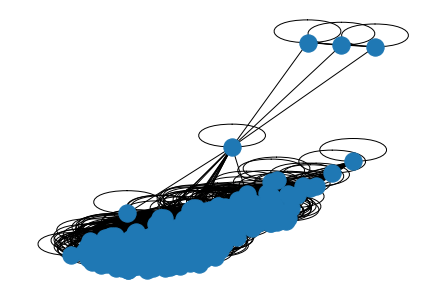

In [8]:
# ------------------- Visualize the graph from cluster ------------------- #
# !!! Very slow when visualizing larger clusters/graphs 

import networkx as nx
from torch_geometric.utils.convert import to_networkx
from sklearn.neighbors import radius_neighbors_graph

cluster_id = 6
clstr_distance = np.load('/Users/muneeza/Documents/GitHub/DATA_SMest/HRU_Clustering_results/'+'dist.in.cluster_'+str(cluster_id)+'.npy')
adj_csr = radius_neighbors_graph( clstr_distance, 1, include_self = True)

G = nx.Graph(adj_csr)
nx.draw(G)

In [ ]:
# ------------------- Visualize the clustering results ------------------- #

for i in range(12):
    